In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import cv2
import os
import numpy as np
import random
from scipy.ndimage import rotate

In [15]:
data_path = '/content/drive/MyDrive/cat_dog_full'

In [4]:
# categories = os.listdir(data_path)
# categories

['cat', 'dog']

In [5]:
# labels = [i for i in range(len(categories))]
# labels

[0, 1]

In [6]:
# label_dict = dict(zip(categories, labels))
# label_dict

{'cat': 0, 'dog': 1}

In [7]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
# import time

In [8]:
# print("\n=== DATA PREPROCESSING FOR TRANSFER LEARNING ===")

# # Load original data without augmentation (same preprocessing as before)
# img_size_tl = 224  # ResNet50 requires 224x224 input
# data_tl = []
# target_tl = []

# print(f"Loading data with image size: {img_size_tl}x{img_size_tl}")

# for category in categories:
#     folder_path = os.path.join(data_path, category)
#     image_names = os.listdir(folder_path)

#     print(f"Processing {category}...")

#     for img_name in image_names:
#         img_path = os.path.join(folder_path, img_name)
#         img = cv2.imread(img_path)

#         try:
#             # Convert to grayscale
#             gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             # Resize for ResNet50 (224x224)
#             resized = cv2.resize(gray, (img_size_tl, img_size_tl))
#             # Convert grayscale to 3-channel for ResNet50 (RGB format)
#             rgb_img = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

#             data_tl.append(rgb_img)
#             target_tl.append(label_dict[category])

#         except Exception as e:
#             print(f'Exception: {e}')

# print(f"\nTransfer Learning dataset loaded:")
# for category in categories:
#     count = target_tl.count(label_dict[category])
#     print(f"{category}: {count} images")
# print(f"Total images for transfer learning: {len(data_tl)}")


=== DATA PREPROCESSING FOR TRANSFER LEARNING ===
Loading data with image size: 224x224
Processing cat...
Processing dog...

Transfer Learning dataset loaded:
cat: 5500 images
dog: 5500 images
Total images for transfer learning: 11000


In [8]:
# # Convert to numpy array and normalize (ResNet50 expects 0-255, we'll use ImageNet preprocessing)
# data_tl = np.array(data_tl, dtype=np.float32)
# target_tl = np.array(target_tl)

# print(f"Data shape before normalization: {data_tl.shape}")

# # ImageNet preprocessing - normalize to [-1, 1] range
# from tensorflow.keras.applications.resnet50 import preprocess_input
# data_tl = preprocess_input(data_tl)

# print(f"Final transfer learning data shape: {data_tl.shape}")
# print(f"Data type: {data_tl.dtype}")
# print(f"Data range: [{data_tl.min():.3f}, {data_tl.max():.3f}]")

# # One-hot encode targets
# from tensorflow.keras.utils import to_categorical
# target_tl_encoded = to_categorical(target_tl, num_classes=len(categories))
# print(f"Transfer learning targets shape: {target_tl_encoded.shape}")

Data shape before normalization: (11000, 224, 224, 3)
Final transfer learning data shape: (11000, 224, 224, 3)
Data type: float32
Data range: [-123.680, 151.061]
Transfer learning targets shape: (11000, 2)


In [ ]:
# from sklearn.model_selection import train_test_split

# print("\n=== TRAIN-TEST SPLIT FOR TRANSFER LEARNING ===")

# x_train_tl, x_test_tl, y_train_tl, y_test_tl = train_test_split(
#     data_tl, target_tl_encoded,
#     test_size=0.2,
#     random_state=42,
#     stratify=target_tl
# )

# print(f"Transfer Learning Training set: {x_train_tl.shape[0]} samples")
# print(f"Transfer Learning Test set: {x_test_tl.shape[0]} samples")
# print(f"Training image shape: {x_train_tl[0].shape}")
# print(f"Test image shape: {x_test_tl[0].shape}")


=== TRAIN-TEST SPLIT FOR TRANSFER LEARNING ===


In [19]:
# === STREAMING DATA LOADER (Option 1) ===
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

img_size = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=img_size,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=img_size,
    batch_size=BATCH_SIZE
)

categories = train_ds.class_names
print("Classes:", categories)

# Apply preprocessing AFTER extracting class_names
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)



Found 11000 files belonging to 2 classes.
Using 8800 files for training.
Found 11000 files belonging to 2 classes.
Using 2200 files for validation.
Classes: ['cat', 'dog']


In [20]:
# Load pre-trained ResNet50 model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size_tl, img_size_tl, 3)
)

print(f"Base model loaded: {base_model.name}")
print(f"Number of layers in base model: {len(base_model.layers)}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model loaded: resnet50
Number of layers in base model: 175


In [21]:
# Freeze the base model initially
base_model.trainable = False
print("Base model layers frozen for feature extraction")

Base model layers frozen for feature extraction


In [22]:
# Build the complete model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout

transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(categories), activation='softmax')  # Binary classification
])

print("\nTransfer Learning Model Architecture:")
transfer_model.summary()


Transfer Learning Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,866,562 (91.04 MB)

 Trainable params: 274,754 (1.05 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [23]:
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Transfer learning model compiled successfully!")

Transfer learning model compiled successfully!


In [24]:
history_tl_phase1 = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 109s 326ms/step - accuracy: 0.9402 - loss: 0.1509 - val_accuracy: 0.9791 - val_loss: 0.0577
Epoch 2/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - accuracy: 0.9794 - loss: 0.0548 - val_accuracy: 0.9832 - val_loss: 0.0489
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 53s 193ms/step - accuracy: 0.9862 - loss: 0.0420 - val_accuracy: 0.9832 - val_loss: 0.0486
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 181ms/step - accuracy: 0.9867 - loss: 0.0390 - val_accuracy: 0.9795 - val_loss: 0.0509
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 49s 178ms/step - accuracy: 0.9891 - loss: 0.0288 - val_accuracy: 0.9805 - val_loss: 0.0473


In [25]:
import numpy as np

y_true = []
y_pred = []

for xb, yb in val_ds:
    preds = transfer_model.predict(xb)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(yb.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

              precision    recall  f1-score   support

         cat       0.98      0.98      0.98      1081
         dog       0.98      0.98      0.98      1119

    accuracy                           0.98      2200
   macro avg       0.98      0.98      0.98      2200
weighted avg       0.98      0.98      0.98      2200



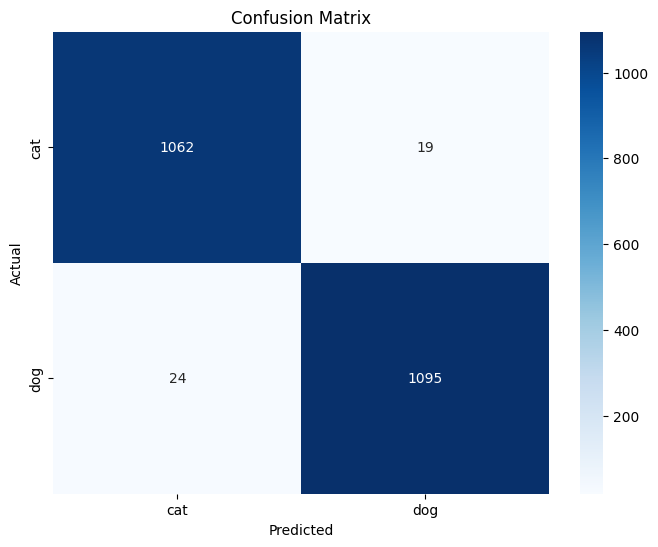

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_true, y_pred, target_names=categories))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


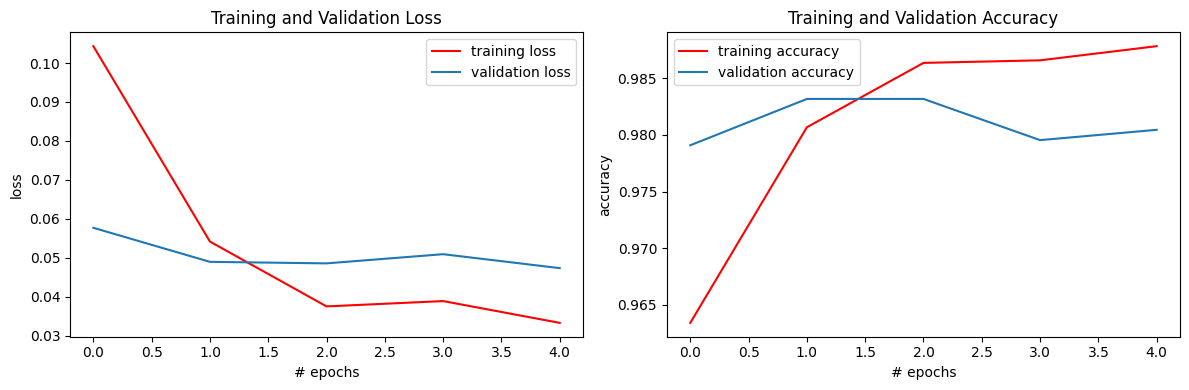

In [27]:
from matplotlib import pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_tl_phase1.history['loss'], 'r', label='training loss')
plt.plot(history_tl_phase1.history['val_loss'], label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history_tl_phase1.history['accuracy'], 'r', label='training accuracy')
plt.plot(history_tl_phase1.history['val_accuracy'], label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()